# NeurIPS 2023 Machine Unlearning Challenge
Heavily based off of the code presented here: https://github.com/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb

Relevant Links:
Fast Yet Effective Unlearning: https://arxiv.org/pdf/2111.08947.pdf and [code repo](https://github.com/vikram2000b/Fast-Machine-Unlearning/blob/main/Machine%20Unlearning.ipynb)

LEACE: https://arxiv.org/pdf/2306.03819.pdf

In [1]:
%%script false --no-raise-error
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

from tqdm import tqdm
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://unlearning-challenge.s3.eu-west-1.amazonaws.com/cifar10/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Running on device: CPU


100%|██████████| 170498071/170498071 [00:05<00:00, 31555912.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Since we can't download the aws weights, I've manually uploaded them to this Kaggle notebook as `unlearning-cifar10-resnet18-weights`

In [3]:
# download pre-trained weights
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://unlearning-challenge.s3.eu-west-1.amazonaws.com/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

# weights_pretrained = torch.load('/kaggle/input/unlearning-cifar10-resnet18-weights/unlearning-cifar10-resnet18-weights/weights_resnet18_cifar10.pth', map_location=DEVICE)
# model = resnet18(weights=None, num_classes=10)
# model.load_state_dict(weights_pretrained)
# model.to(DEVICE)
# model.eval()

Look at sample images

In [4]:
%%script false --no-raise-error

# a temporary data loader without normalization, just to show the images
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

## Accuracy Equation

In [5]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in tqdm(loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [6]:
print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Train set accuracy: 99.5%


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]

Test set accuracy: 88.3%


# Unlearning Algorithm
In this section we develop the unlearning algorithm.

In the previous section we created a split of the original training set into a retain set and a forget set. Typically, the retain set is much larger than the forget set. Here, we produce a split that is 10% forget set, and 90% retain set.

The goal of an unlearning algorithm is to produce a model that approximates as much as possible the model trained solely on the retain set.

Below is a simple unlearning algorithm provided for illustration purposes. We call this algorithm unlearning by fine-tuning. It starts from the pre-trained model and optimizes it for a few epochs on the retain set. This is a very simple unlearning algorithm, but it is not very computationally efficient, and we don't expect it to work very well for most metrics.

To make a new entry in the competition, participants will submit an unlearning function with the same API as the one below. Note that the unlearning function takes as input a pre-trained model, a retain set, a forget set and an evaluation set (even though the fine-tuning algorithm below only uses the retain set and ignores the other datasets).

In [7]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        print(f'epoch {_}')
        for inputs, targets in tqdm(retain):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [8]:
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
ft_model = unlearning(ft_model, retain_loader, forget_loader, test_loader)

epoch 0


100%|██████████| 352/352 [04:39<00:00,  1.26it/s]


epoch 1


100%|██████████| 352/352 [04:39<00:00,  1.26it/s]


epoch 2


100%|██████████| 352/352 [04:39<00:00,  1.26it/s]


epoch 3


100%|██████████| 352/352 [04:42<00:00,  1.25it/s]


epoch 4


100%|██████████| 352/352 [04:47<00:00,  1.22it/s]


In [10]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")

100%|██████████| 352/352 [01:02<00:00,  5.63it/s]


Retain set accuracy: 98.3%


100%|██████████| 40/40 [00:07<00:00,  5.55it/s]

Test set accuracy: 83.5%


In [11]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in tqdm(loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [12]:
train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

100%|██████████| 40/40 [00:07<00:00,  5.61it/s]


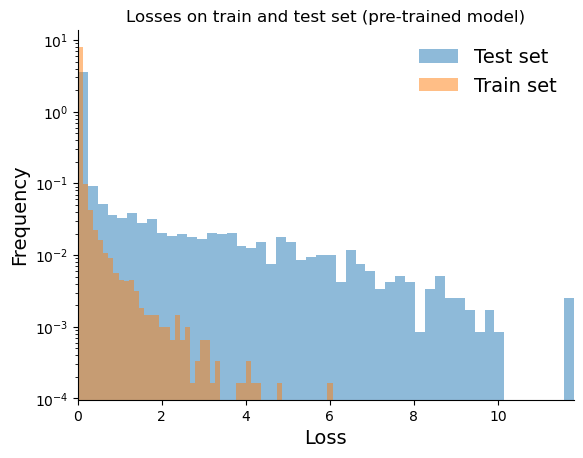

In [13]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [14]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [15]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

100%|██████████| 40/40 [00:07<00:00,  5.54it/s]


The MIA has an accuracy of 0.577 on forgotten vs unseen images


In [16]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

100%|██████████| 40/40 [00:07<00:00,  5.46it/s]


In [17]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.513 on forgotten vs unseen images


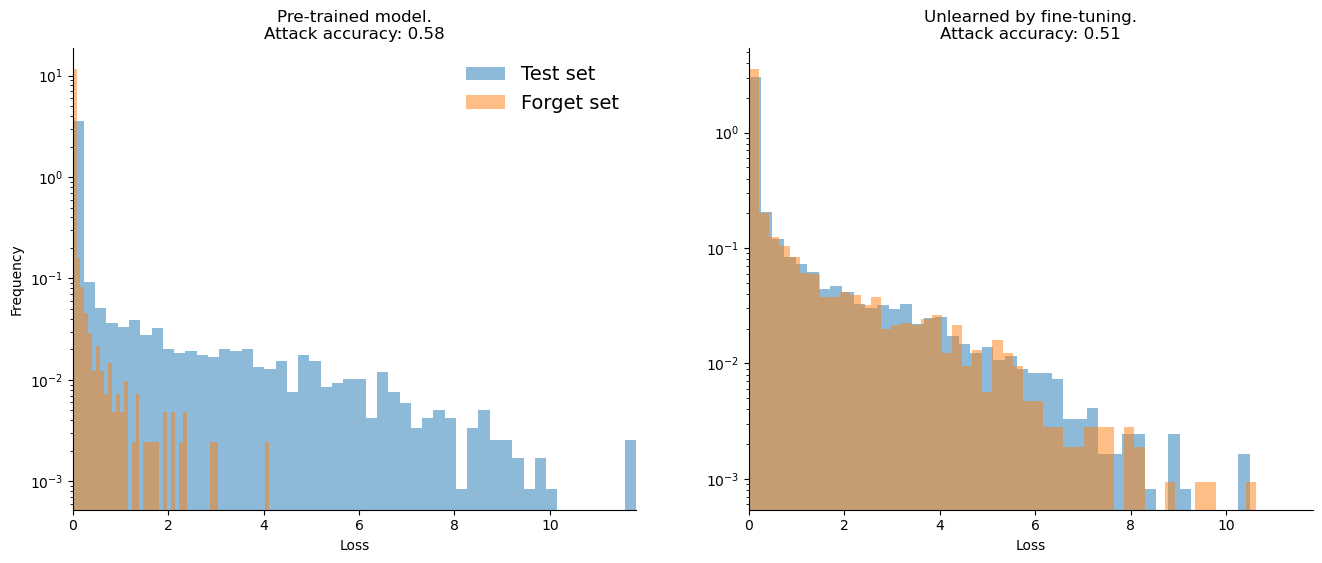

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Load Re-trained model

In [19]:
# weights_pretrained = torch.load('/kaggle/input/unlearning-cifar10-resnet18-weights/unlearning-cifar10-resnet18-weights/retrain_weights_resnet18_cifar10.pth', map_location=DEVICE)

# # load model with pre-trained weights
# rt_model = resnet18(weights=None, num_classes=10)
# rt_model.load_state_dict(weights_pretrained)
# rt_model.to(DEVICE)
# rt_model.eval()

# download weights of a model trained exclusively on the retain set
local_path = "retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://unlearning-challenge.s3.eu-west-1.amazonaws.com/cifar10/" + local_path
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

100%|██████████| 352/352 [01:03<00:00,  5.57it/s]


Retain set accuracy: 99.5%


100%|██████████| 40/40 [00:07<00:00,  5.48it/s]

Forget set accuracy: 88.2%


In [20]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


In [21]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.496 on forgotten vs unseen images


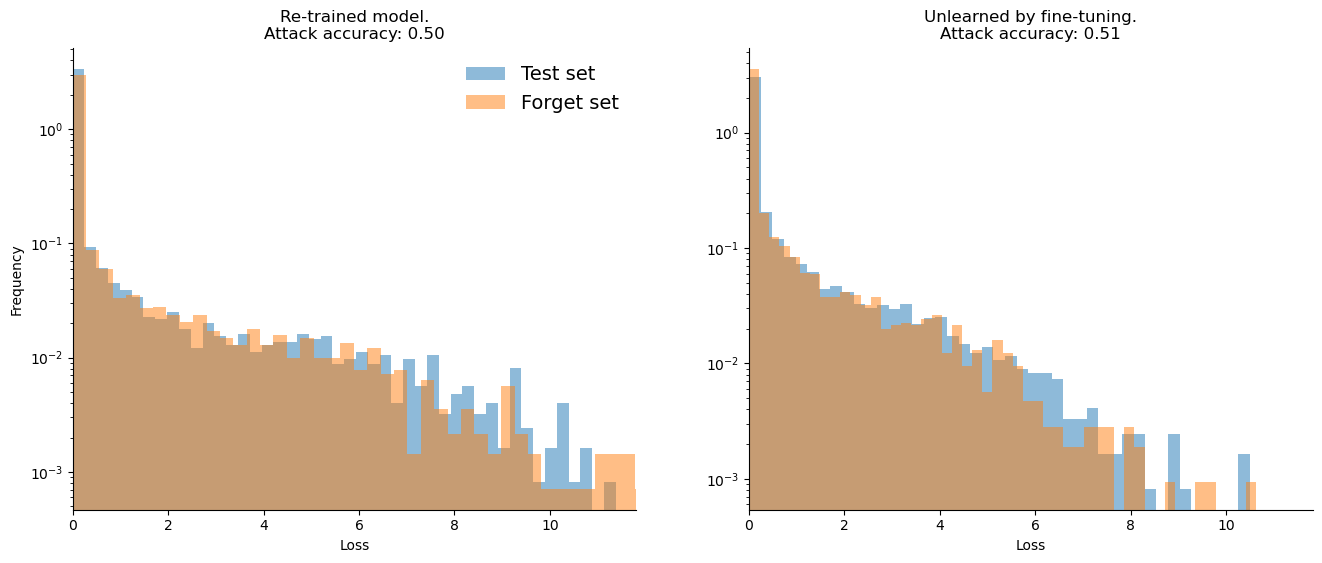

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

# Attempts:

In [23]:
# Input model load
in_model = resnet18(weights=None, num_classes=10)
in_model.load_state_dict(weights_pretrained)
in_model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Attempt v0.0
Just a test to see what happens when you multiply the loss value by -1 when training using the forget dataset

In [24]:
def repair_model(net, retain, itter):
    """Repairs the given model using a couple itterations
    of the retain dataset
    
    Args:
        net: nn.Module
            degraded model
        retain : torch.utils.data.DataLoader.
            Dataset loader for access to the retain set. This is the subset
            of the training set that we don't want to forget.
        itter: int
            Number of iterations to repair the model for
    
    Returns:
        net: nn.Module
            repaired model
    
    """
    
    epochs = 2

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        print(f'epoch {_}')
        for inputs, targets in tqdm(retain):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net
    
def degrade_model(net, forget, epoch):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
#     optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.009, weight_decay=5e-4)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
    net.train()
    
    for i in tqdm(range(epoch)):
        inputs, targets = next(iter(forget))
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = -1 * criterion(outputs, targets)
        loss.backward()
        optimizer.step()
#     scheduler.step()

    net.eval()
    return net
    
    
    
def unlearner_v0(net, retain, forget, validation):
    """Unlearning through noise.

    Args:
        net : nn.Module.
            pre-trained model to use as base of unlearning.
        retain : torch.utils.data.DataLoader.
            Dataset loader for access to the retain set. This is the subset
            of the training set that we don't want to forget.
        forget : torch.utils.data.DataLoader.
            Dataset loader for access to the forget set. This is the subset
            of the training set that we want to forget. This method doesn't
            make use of the forget set.
        validation : torch.utils.data.DataLoader.
            Dataset loader for access to the validation set. This method doesn't
            make use of the validation set.
            
        f_size : int
            The size of the mini-batches used for the training of the noisy image
        
    Returns:
          new_net : nn.Module
              Updated model
    """
    
    # Train the noise layer on the forget dataset sample
    inputs, targets = next(iter(forget))
    
    for j in range(3):
        print(f'itteration {j}')
        # Train the network using the noise layer
        net = degrade_model(net.train(), forget, 5)

        # Repair by training with sample of retain dataset sample
        net = repair_model(net.train(), retain, 5)
    

    return net

In [25]:
import copy
model_copy = copy.deepcopy(in_model)

v0_model = unlearner_v0(model_copy, retain_loader, forget_loader, test_loader)

itteration 0


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


epoch 0


100%|██████████| 352/352 [04:51<00:00,  1.21it/s]


epoch 1


100%|██████████| 352/352 [04:54<00:00,  1.20it/s]


itteration 1


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


epoch 0


100%|██████████| 352/352 [04:43<00:00,  1.24it/s]


epoch 1


100%|██████████| 352/352 [04:43<00:00,  1.24it/s]


itteration 2


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


epoch 0


100%|██████████| 352/352 [04:46<00:00,  1.23it/s]


epoch 1


100%|██████████| 352/352 [04:41<00:00,  1.25it/s]


In [26]:
print(f"Train set accuracy: {100.0 * accuracy(in_model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(in_model, test_loader):0.1f}%")
print(f"Retrain set accuracy: {100.0 * accuracy(in_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(in_model, forget_loader):0.1f}%")

print(f"Train set accuracy: {100.0 * accuracy(v0_model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(v0_model, test_loader):0.1f}%")
print(f"Retain set accuracy: {100.0 * accuracy(v0_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(v0_model, forget_loader):0.1f}%")

# Additional retain results:
# Train = 98.4
# Test = 82.8
# Retain = 99.9
# Forget = 84.4

# 95, 91, 79, 92, 79

100%|██████████| 391/391 [01:14<00:00,  5.28it/s]


Train set accuracy: 96.0%


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


Test set accuracy: 85.0%


100%|██████████| 352/352 [01:07<00:00,  5.18it/s]


Retrain set accuracy: 97.1%


100%|██████████| 40/40 [00:07<00:00,  5.13it/s]


Forget set accuracy: 85.6%


100%|██████████| 391/391 [01:10<00:00,  5.54it/s]


Train set accuracy: 90.7%


100%|██████████| 40/40 [00:07<00:00,  5.65it/s]


Test set accuracy: 78.5%


100%|██████████| 352/352 [01:02<00:00,  5.60it/s]


Retain set accuracy: 91.9%


100%|██████████| 40/40 [00:07<00:00,  5.59it/s]

Forget set accuracy: 79.1%


In [27]:
v0_test_losses = compute_losses(v0_model, test_loader)
v0_forget_losses = compute_losses(v0_model, forget_loader)

v0_samples_mia = np.concatenate((v0_test_losses, v0_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(v0_test_losses) + [1] * len(v0_forget_losses)

100%|██████████| 40/40 [00:07<00:00,  5.43it/s]


In [28]:
v0_mia_scores = simple_mia(v0_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {v0_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.492 on forgotten vs unseen images


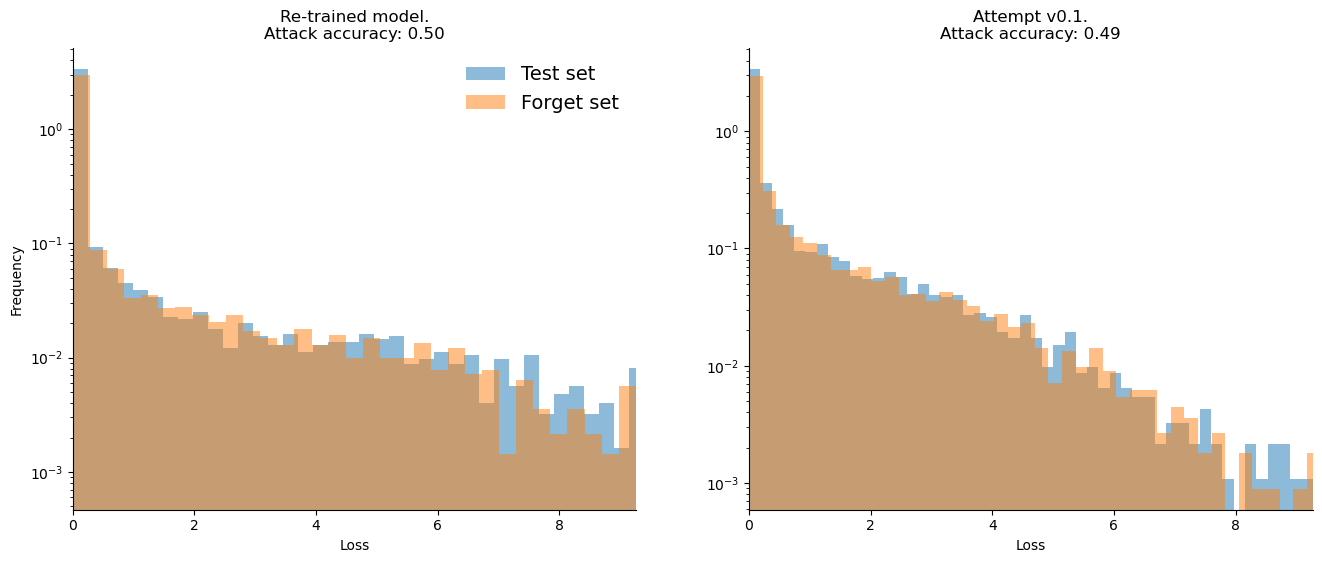

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Attempt v0.1.\nAttack accuracy: {v0_mia_scores.mean():0.2f}"
)
ax2.hist(v0_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(v0_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(v0_test_losses)))
ax2.set_xlim((0, np.max(v0_test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Attempt v1.0
Using the [Fast Yet Effective Machine Unlearning](https://arxiv.org/pdf/2111.08947.pdf) with [code](https://github.com/vikram2000b/Fast-Machine-Unlearning/blob/main/Machine%20Unlearning.ipynb) as inspiration. The idea behind this model is to selectively train a layer to generate a noisy image to be added to each of the target forget images. A few questions still to be answered:
- Can the noisy image be generated for multiple images at the same time? As in, pairs of 2/5/10/... images are used to train the noise. That would significantly reduce the amount of time it takes to forget.
- Is it better to generate this noisy image for groups based on classes?

In [30]:
%%script false --no-raise-error
# Create Noise Class
class Noise(nn.Module):
    def __init__(self, *dim):
        super().__init__()
        self.noise = torch.nn.Parameter(torch.randn(*dim), requires_grad = True)
    
    def forward(self):
        return self.noise

In [31]:
%%script false --no-raise-error
def train_noise(net, noise, inputs, targets):
    """Train the noisy layer
    
    Args:
        net : nn.Module
            pre-trained model with weights locked
        noise : nn.Module
            noisy layer
        inputs : ???
            subset of images from the forget
        targets : ???
            vector of labels
    
    Returns:
        noise : np.array
    
    """
    
#     print(noise.get_parameter('noise'))
    
    epochs = 50
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(noise.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    print('Training Noise:')
    for _ in tqdm(range(epochs)):
#         print(f'epoch {_}')
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs + noise())
        loss = criterion(outputs, targets)
        loss = loss * -1
#         print(loss.detach())
        loss.backward()
        optimizer.step()
    scheduler.step()

    return noise
    

def degrade_model(net, noise, inputs, targets):
    """Takes the given model and noise and uses that to
    degrade the model
    
    Args:
        net : nn.Module
            pre-trained model to degrade
        noise : nn.Module
            generated noise image to add to inputs
        target : ???
        
    Returns:
        net : nn.Module
            Degraded network
    
    """
    epochs = 3
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()
    
    print('Degrading Model:')
    for _ in tqdm(range(epochs)):
#         print(f'epoch {_}')
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs + noise())
        loss = criterion(outputs, targets)
#         print(loss.detach())
        loss.backward()
        optimizer.step()
    scheduler.step()

    return net
    
def repair_model(net, retain, itter):
    """Repairs the given model using a couple itterations
    of the retain dataset
    
    Args:
        net: nn.Module
            degraded model
        retain : torch.utils.data.DataLoader.
            Dataset loader for access to the retain set. This is the subset
            of the training set that we don't want to forget.
        itter: int
            Number of iterations to repair the model for
    
    Returns:
        net: nn.Module
            repaired model
    
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=itter)
    net.train()

    print('Repairing Model:')
    for _ in tqdm(range(itter)):
#         print(f'itter {_}')
#         for inputs, targets in tqdm(retain):
        inputs, targets =  next(iter(retain))
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    scheduler.step()

    net.eval()
    return net
    
    
    
def unlearner_v10(net, retain, forget, validation, f_size):
    """Unlearning through noise.

    Args:
        net : nn.Module.
            pre-trained model to use as base of unlearning.
        retain : torch.utils.data.DataLoader.
            Dataset loader for access to the retain set. This is the subset
            of the training set that we don't want to forget.
        forget : torch.utils.data.DataLoader.
            Dataset loader for access to the forget set. This is the subset
            of the training set that we want to forget. This method doesn't
            make use of the forget set.
        validation : torch.utils.data.DataLoader.
            Dataset loader for access to the validation set. This method doesn't
            make use of the validation set.
            
        f_size : int
            The size of the mini-batches used for the training of the noisy image
        
    Returns:
          new_net : nn.Module
              Updated model
    """
    
    # Train the noise layer on the forget dataset sample
    inputs, targets = next(iter(forget))
    
    noise = Noise(inputs.shape).to(DEVICE)
    
    noise = train_noise(net.eval(), noise.train(), inputs, targets)
    
    # Train the network using the noise layer
    net = degrade_model(net.train(), noise.eval(), inputs, targets)
    
    # Repair by training with sample of retain dataset sample
    net = repair_model(net.train(), retain, 300)
    
    return net


In [32]:
%%script false --no-raise-error
import copy
model_copy = copy.deepcopy(ft_model)

v10_model = unlearner_v10(ft_model, retain_loader, forget_loader, test_loader, None)

In [33]:
%%script false --no-raise-error
print(f"Train set accuracy: {100.0 * accuracy(v10_model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(v10_model, test_loader):0.1f}%")
print(f"Retain set accuracy: {100.0 * accuracy(v10_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(v10_model, forget_loader):0.1f}%")

In [34]:
%%script false --no-raise-error
v10_test_losses = compute_losses(v10_model, test_loader)
v10_forget_losses = compute_losses(v10_model, forget_loader)

v10_samples_mia = np.concatenate((v10_test_losses, v10_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(v10_test_losses) + [1] * len(v10_forget_losses)

In [35]:
%%script false --no-raise-error
v10_mia_scores = simple_mia(v10_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {v10_mia_scores.mean():.3f} on forgotten vs unseen images"
)

In [36]:
%%script false --no-raise-error
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Attempt v1.0 \nAttack accuracy: {v10_mia_scores.mean():0.2f}"
)
ax2.hist(v10_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(v10_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(v10_test_losses)))
ax2.set_xlim((0, np.max(v10_test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()